In [1]:
import pandas as pd
import numpy as np
import shap
import pickle

In [2]:
x = pd.read_pickle('../Tables/feature_df.pkl')
y = pd.read_csv('../Tables/target_df.csv').drop(columns=['Unnamed: 0'])

In [3]:
y['state'] = y['state'].replace({'successful': 1, 'failed': 0})

In [4]:
x_train = pd.read_pickle('../Tables/x_train.pkl')
x_test = pd.read_pickle('../Tables/x_test.pkl')
y_train = pd.read_pickle('../Tables/y_train.pkl')
y_test = pd.read_pickle('../Tables/y_test.pkl')
model = pickle.load(open('../Models/finalized_model.pkl', 'rb'))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


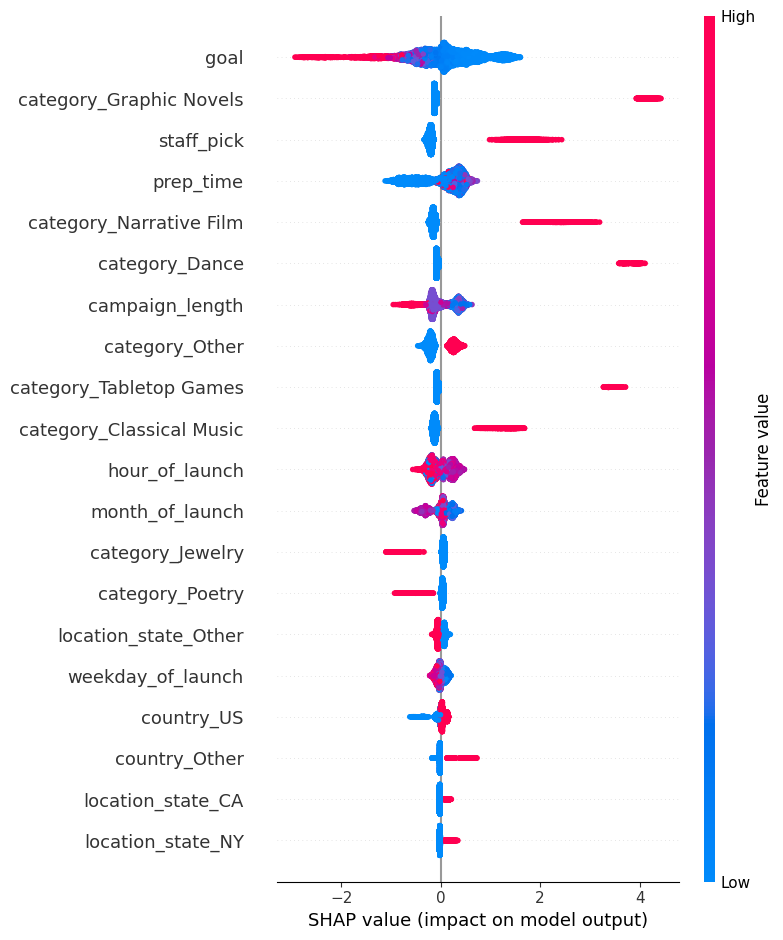

In [5]:
# Explain the entire dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_test)
shap.summary_plot(shap_values, x_test)

In [6]:
# Enforce underlying data dtypes to ensure graphing functions correctly (ran into error appending string and boolean datatypes in underlying data)

shap_values.data = shap_values[0:].data.astype('str')

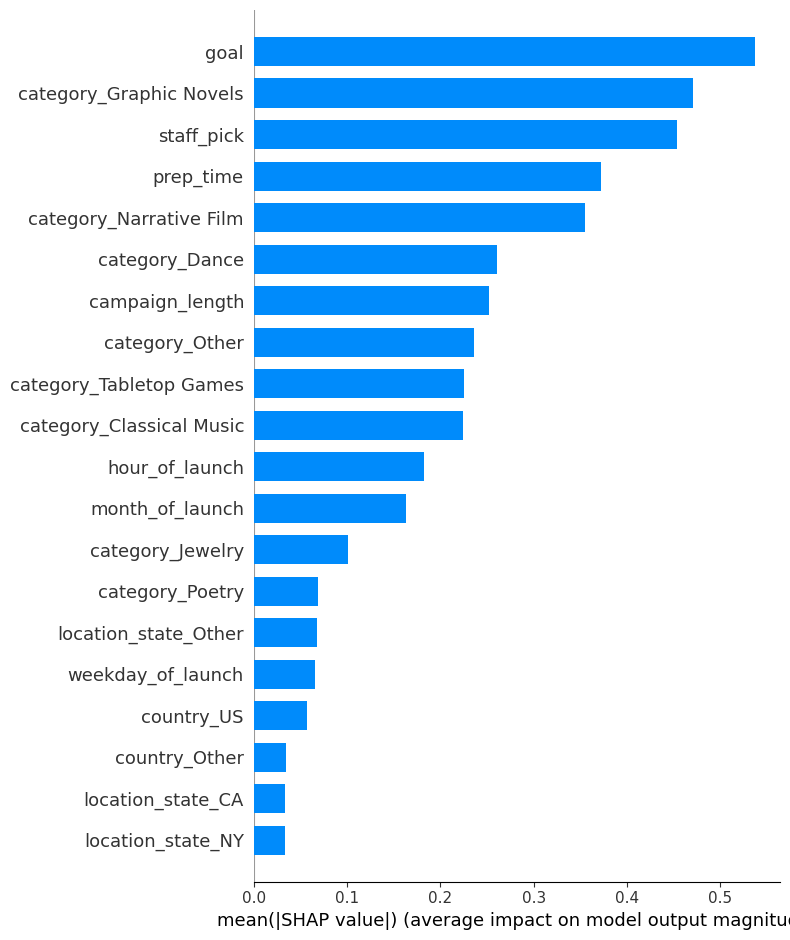

In [7]:
# Top 20 most influential features for affecting model output
shap.summary_plot(shap_values, x_test, plot_type='bar')

In [8]:
# use the original data to determine id column

x.head(1)

,goal,id,campaign_length,prep_time,month_of_launch,weekday_of_launch,hour_of_launch,staff_pick,is_starrable,location_state_CA,...,category_Classical Music,category_Dance,category_Graphic Novels,category_Jewelry,category_Narrative Film,category_Other,category_Performances,category_Poetry,category_Tabletop Games,category_Wearables
0,10000.0,522081392,49,17,2,6,20,False,False,True,...,False,False,False,False,True,False,False,False,False,False


In [9]:
# Explain an Individual Row
# Enter an column used to identify and the value of the row you are looking for
row_id_value = 522081392
id_column_name = 'id'

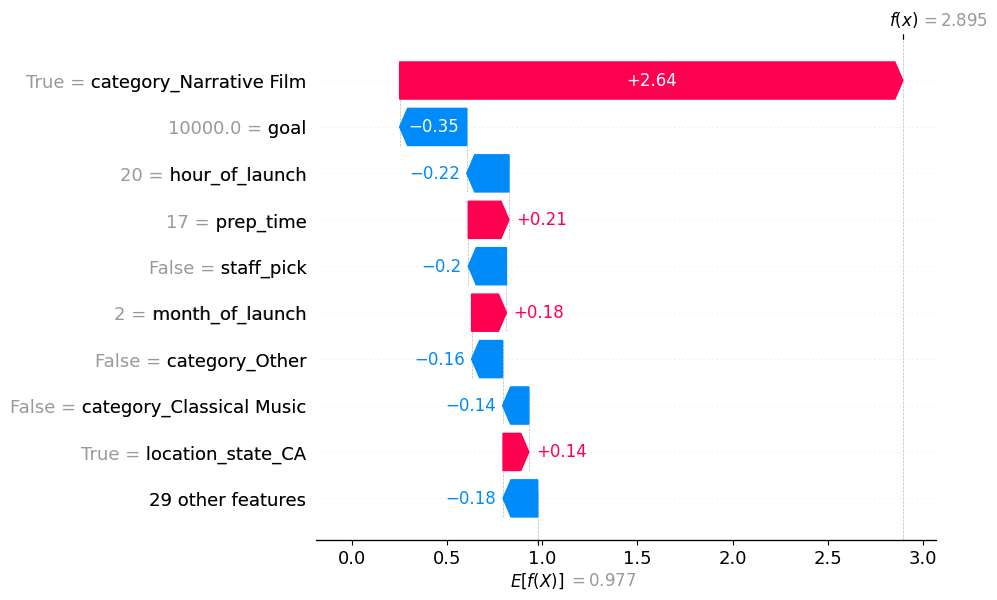

In [10]:
# requires x_test set for predications and shap values
shap_test = x_test.copy()
x_id = x.copy()
x_id = x_id[[id_column_name]]
shap_test['order'] = np.arange(len(shap_test))
shap_test_id = shap_test.merge(x_id, left_index=True, right_index=True)
shap_reference = shap_test_id[shap_test_id[id_column_name]==row_id_value]['order'].values[0]
shap.plots.waterfall(shap_values[:,:][shap_reference])

In [11]:
# Create a full df with shap values at each row
def concat_shap(feature):
    return(feature+'_shap')

full_df = pd.concat([x_test, y_test], axis=1)
full_df['order'] = np.arange(len(full_df))
features = x_test.columns.values
shap_feature_names = np.apply_along_axis(concat_shap,0,features)
sorted_shap_feature_names = np.sort(shap_feature_names)

shap_df = pd.DataFrame(columns=sorted_shap_feature_names)

for o in full_df['order']:
    index = float(full_df[full_df['order']==o].index[0])
    vals = shap_values[:,:][o].values
    features = x_test.columns.values
    features_shap = np.apply_along_axis(concat_shap, 0, features)
    shap_row = pd.DataFrame(list(zip(features_shap, vals)), columns=['col_name','shap_value'])
    shap_row_sorted = shap_row.sort_values(by=['col_name'])
    shap_row_transposed = shap_row_sorted.set_index('col_name').T
    shap_df = pd.concat([shap_df, shap_row_transposed], ignore_index= True)

full_shap_df = shap_df.merge(full_df, left_index=True, right_on=['order'])

In [12]:
full_shap_df.to_pickle('../Tables/full_shap_df.pkl')